In [1]:
import sys
sys.path.append("../")
from libraries.dataManipulation import *
from libraries.gridManipulation import *
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import random
import warnings
warnings.filterwarnings(action='ignore')
import time

In [2]:
from sociophysicsDataHandler import SociophysicsDataHandler

In [3]:
def convert_to_unixtimestamp(datetime_utc):
    return (datetime_utc - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [4]:
#Check for train
#TODO
def check_train(timestamp):
    train_present = False

In [5]:
#Spawn people
def spawn_people(timestamp):
    global current_ID, simulation_tuple
    if timestamp in people_in_dictionary_off:
        spawn_zones = people_in_dictionary_off[timestamp]
        for zone in spawn_zones:
            offboarding_people_locs[current_ID] = zone
            simulation_tuple.extend([[current_ID,True,False,timestamp,zone]])
            
            density[zone_to_coordinate(zone)] += 1/zone_area
            current_ID += 1
    
    if timestamp in people_in_dictionary_on:
        spawn_zones = people_in_dictionary_on[timestamp]
        for zone in spawn_zones:
            onboarding_people_locs[current_ID] = zone
            simulation_tuple.extend([[current_ID,False,True,timestamp,zone]])
            
            density[zone_to_coordinate(zone)] += 1/zone_area
            current_ID += 1

In [6]:
#Determine the density based on the locations of people
#DEPRECATED
def calculate_density():
    locs = {**onboarding_people_locs,**offboarding_people_locs}
    
    density = density_0
    
    #Cycle through all the people in the locs dictionary
    for i in locs.keys():
        density[zone_to_coordinate(locs[i])] += 1/zone_area
        
    return density

In [7]:
#Convert the density matrix into a 3x3 matrix of surrounding zone densities
#The area of 5x5 squares around the midpoint will be taken into account by averaging them into the 3x3 matrix
#The midpoint will be a tuple of the form (zone_row,zone_column)
def get_density_matrix(density_matrix, current_zone):
    density_matrix_5 = np.zeros([5,5])
    midpoint = zone_to_coordinate(current_zone)

    for i in range(5):
        for j in range(5):
            coords = ( min(max(midpoint[0]+i-2,0),zone_rows-1), min(max(midpoint[1]+j-2,0),zone_columns-1) )
            density_matrix_5[i,j] = density[coords]
    
    #Convert the 5x5 density matrix into a 3x3 one
    density_matrix_5_3 = np.zeros([5,3])
    
    density_matrix_5_3[:,0] = 0.3 * density_matrix_5[:,0] + 0.7 * density_matrix_5[:,1]
    density_matrix_5_3[:,1] = density_matrix_5[:,2]
    density_matrix_5_3[:,2] = 0.7 * density_matrix_5[:,3] + 0.3 * density_matrix_5[:,4]
    
    density_matrix_3 = np.zeros([3,3])
    
    density_matrix_3[0,:] = 0.3 * density_matrix_5_3[0,:] + 0.7 * density_matrix_5_3[1,:]
    density_matrix_3[1,:] = density_matrix_5_3[2,:]
    density_matrix_3[2,:] = 0.7 * density_matrix_5_3[3,:] + 0.3 * density_matrix_5_3[4,:]
    
    density_matrix_3 = density_matrix_3.flatten() #Put the matrix in the flattened form
    
    #Add zeros for void_zones density
    for i in range(void_zones):
        density_matrix_3 = np.append(density_matrix_3,0)
    
    return density_matrix_3 

In [8]:
#Get a 3x3 probability matrix around the midpoint of moving to the neighbouring zone or staying
def get_probability_matrix(markov_matrix, current_zone):
    prob_matrix = np.zeros(9 + void_zones)
    midpoint = zone_to_coordinate(current_zone)
    
    k = 0
    for i in range(3):
        for j in range(3):
            x = midpoint[1] + j-1
            y = midpoint[0] + i-1
            
            if not (0 <= x < zone_columns):
                prob_matrix[k] = 0
                k += 1
    
            elif not (0 <= y < zone_rows):
                prob_matrix[k] = 0
                k += 1
                
            else:
                coords = (y,x)
                zone_nr = coordinate_to_zone(coords)
                prob_matrix[k] = markov_matrix[zone_nr][current_zone]
                k += 1
    
    for i in range(void_zones):
        prob_matrix[9+i] = markov_matrix[n_zones + i][current_zone]
        
    return prob_matrix

In [9]:
#Convert zone number to coordinate in zone grid
def zone_to_coordinate(zone_nr):
    x_pos = math.floor(zone_nr/zone_rows)
    y_pos = zone_nr % zone_rows
    return (y_pos,x_pos) #Return in the form of row nr., column nr., which corresponds to y,x

In [10]:
#Convert coordinate 
def coordinate_to_zone(coord):
    x = coord[1] #equivalent to column nr.
    y = coord[0] #equivalent to row nr.
    return x*4 + y
    

In [11]:
#Convert density/probability array index to zone offset
def array_index_to_zone_offset(index):
    x_offset = index % 3 -1 #Column nr. offset
    y_offset = math.floor(index/3) - 1 #Row nr. offset
    return (y_offset, x_offset)

In [12]:
#Function to relate density to probability adjustment factor
#Input is a array of densities
def density_probability_function(density):
    factor = 1 -( 1.15-1.15 * np.power( math.e,-2*(density/max_density) ) )
    return factor

In [13]:
#Adjust the probabilities of moving between zones according to density in neighbouring zones
#The input probabilities is an 1D array for several zones
def adjust_probability(probabilities, density):
    probabilities = probabilities * density_probability_function( density )
    probabilities[probabilities<0] = 0
    return probabilities

In [14]:
#Get a new zone for a person a markov matrix and a randomly generated number
def get_new_zone(current_zone, markov_matrix):

    #Get the probabilities for the zone and apply the randomness
    probabilities = get_probability_matrix(markov_matrix,current_zone)
    densities = get_density_matrix(density,current_zone) #Densities in the adjacent zones
    probabilities = adjust_probability(probabilities, densities)
    
    i = 0 #Iterator to keep track of which column/movement must be selected
    if (sum(probabilities) == 0):
        rand  = 0
    else:
        rand = random.random() * sum(probabilities)
        
    while rand > probabilities[i]:
        rand -= probabilities[i]
        i += 1
    
    if (i > 8):
        return n_zones
    
    coord_offset = array_index_to_zone_offset(i)
    current_coord = zone_to_coordinate(current_zone)
    new_coord = (current_coord[0] + coord_offset[0], current_coord[1] + coord_offset[1])
    return coordinate_to_zone(new_coord)
    

In [15]:
#Change the position of people according to the corresponding markov matrix
def move():
    global simulation_tuple
    
    #Loop through offboarders with markov matrix adjusted for density
    markov_matrix = markov_matrix_offboarding
    
    for offboarder_ID, current_zone in offboarding_people_locs.items():
        
        new_zone = get_new_zone(current_zone, markov_matrix)
        
        offboarding_people_locs[offboarder_ID] = new_zone
        simulation_tuple.extend([[offboarder_ID,True,False,time,new_zone]])
        
        density[zone_to_coordinate(current_zone)] -= 1/zone_area
        density[zone_to_coordinate(new_zone)] += 1/zone_area
    
    #Loop through onboarders with markov matrix adjusted for density and whether there is a train
    if train_present:
        markov_matrix = markov_matrix_onboarding_train
    else:
        markov_matrix = markov_matrix_onboarding_no_train
        
    for onboarder_ID, current_zone in onboarding_people_locs.items():
        
        new_zone = get_new_zone(current_zone, markov_matrix)

        onboarding_people_locs[onboarder_ID] = new_zone
        simulation_tuple.extend([[onboarder_ID,False,True,time,new_zone]])
        
        density[zone_to_coordinate(current_zone)] -= 1/zone_area
        density[zone_to_coordinate(new_zone)] += 1/zone_area
         

In [16]:
%%time

#Initialize variables
start_date_time = pd.to_datetime('2020-04-20T12:00:00') #Starting time of simulation
time = convert_to_unixtimestamp(start_date_time)
sim_duration = 3600 #How long the simulation lasts in seconds

train_present = False

#Number of zones
zone_rows = 4
zone_columns = 18
n_zones = zone_rows * zone_columns
void_zones = 0 #Number of zones that people can disappear to

#Variables that have to be determined in different steps
markov_matrix_offboarding = pd.read_csv('test_markov_matrix.csv', header=None)
markov_matrix_onboarding_no_train =  pd.read_csv('test_markov_matrix.csv', header=None)
markov_matrix_onboarding_train =  pd.read_csv('test_markov_matrix.csv',header=None)
density_influence_table = None
people_in_dictionary_off = {time:range(60)} #[50,51,52,53,54,55]}
people_in_dictionary_on = {time:range(60)} #[1,2,3,4,5,6]}

#Information about people
current_ID = 1000 #People will also have an ID in the simulation, only a different one
offboarding_people_locs = {} #Dictionary with person IDs as keys and zone IDs as values
onboarding_people_locs = {} #Dictionary with person IDs as keys and zone IDs as values

#Density informationt
max_density = 4 #TODO
zone_area = 2 #TODO
#Set all densities to 0
density_0 = np.zeros([zone_rows,zone_columns])
density = density_0 #Dictionary with zone IDs as keys and density as values

#Create dataframe to store the data over time
simulation_tuple = ([[0,False,False,0,0]])

# SIMULATE 

#Start looping
for i in range(sim_duration):
    
    check_train(time)
    
    move()
    
    spawn_people(time)
    
    time += 1

simulation_df = pd.DataFrame(list(simulation_tuple), columns = ['ID','Offboarding','Onboarding','Time','Zone'])
simulation_df = simulation_df.drop(0)
simulation_df['x_pos'] = simulation_df['Zone'].divide(zone_rows).apply(np.floor)
simulation_df['y_pos'] = (simulation_df['Zone']).mod(zone_rows)
simulation_df.head()

Wall time: 39.7 s


,ID,Offboarding,Onboarding,Time,Zone,x_pos,y_pos
1,1000,True,False,1587384000,0,0.0,0
2,1001,True,False,1587384000,1,0.0,1
3,1002,True,False,1587384000,2,0.0,2
4,1003,True,False,1587384000,3,0.0,3
5,1004,True,False,1587384000,4,1.0,0


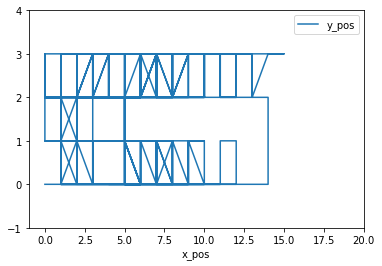

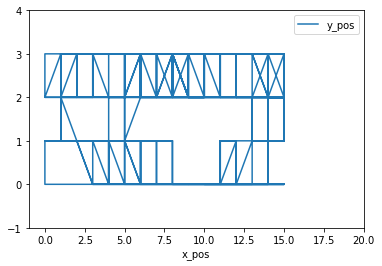

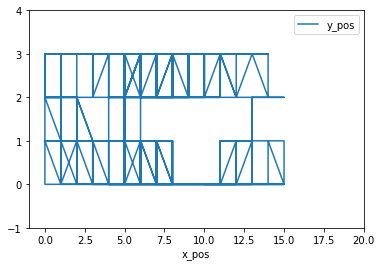

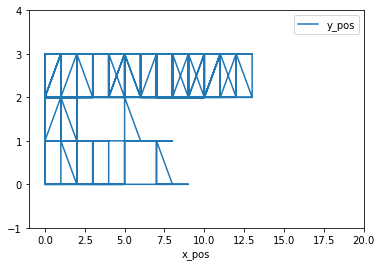

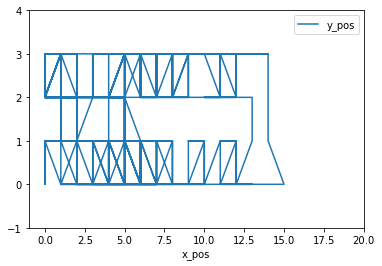

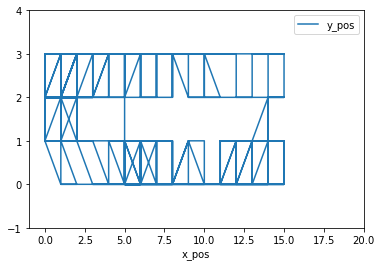

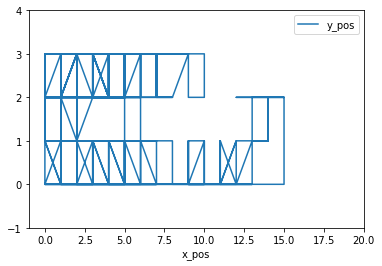

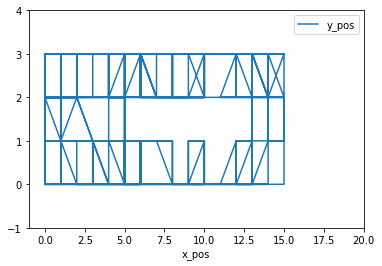

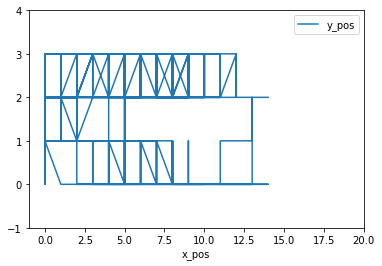

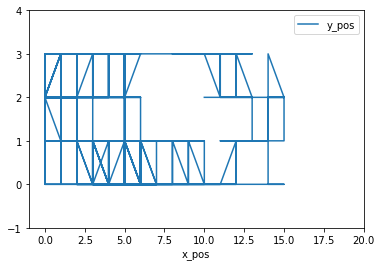

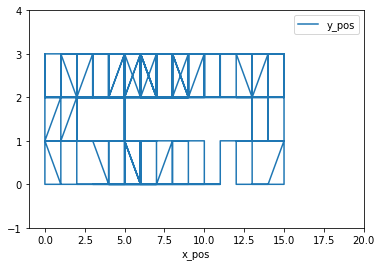

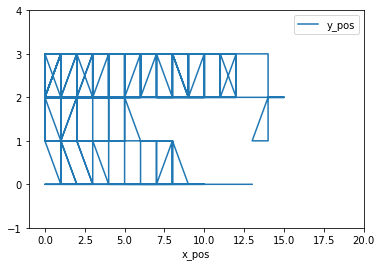

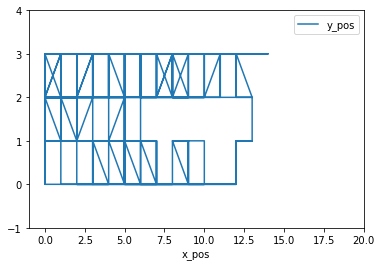

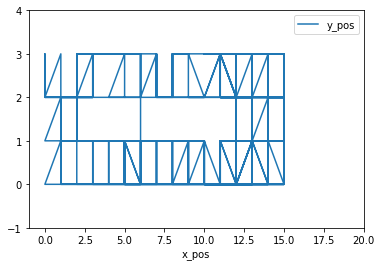

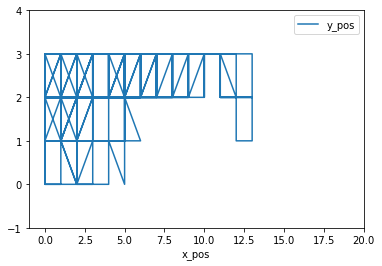

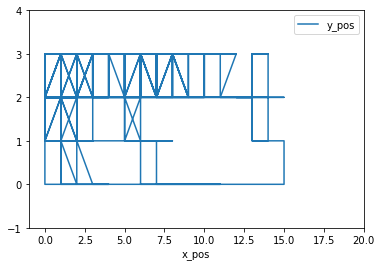

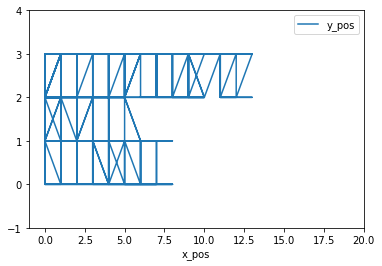

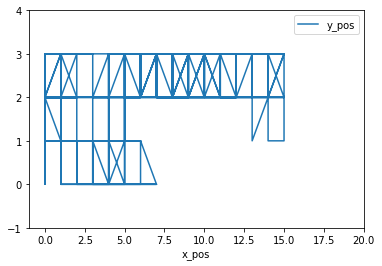

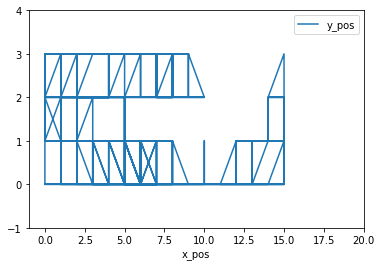

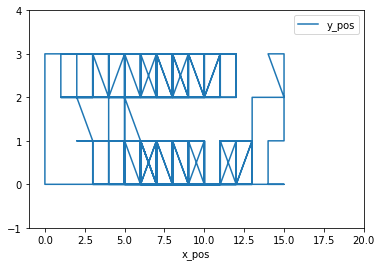

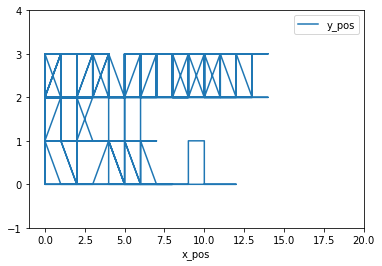

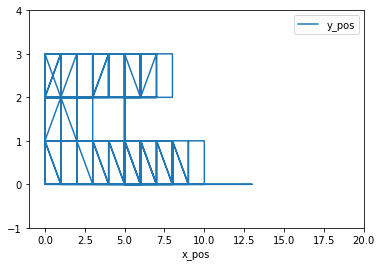

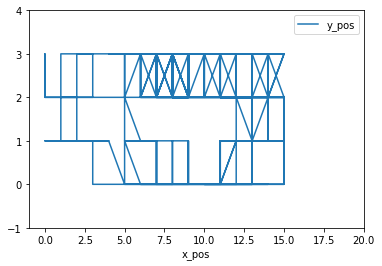

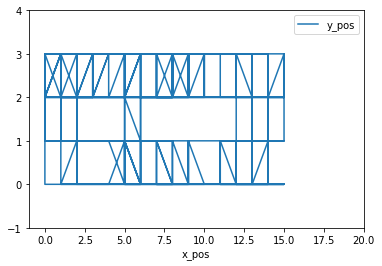

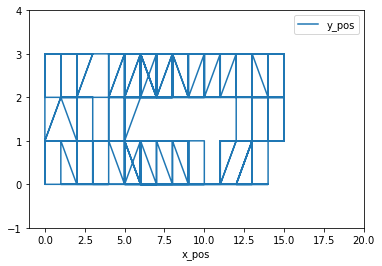

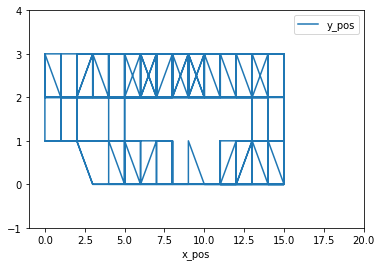

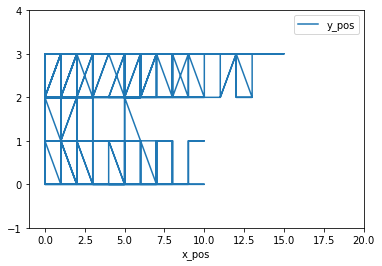

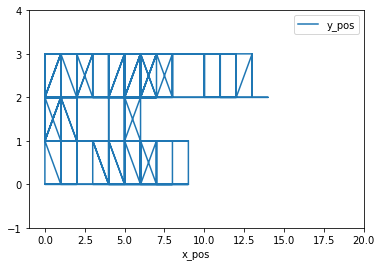

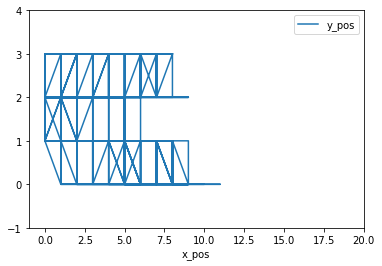

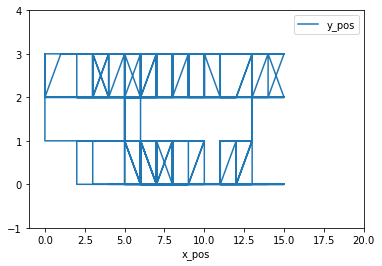

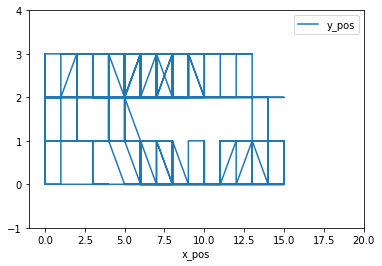

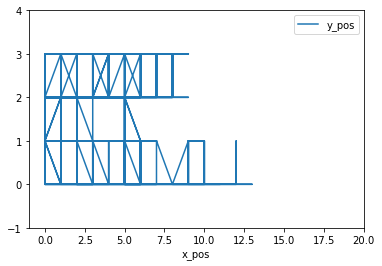

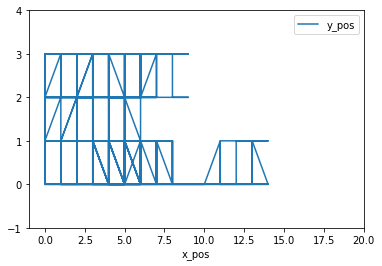

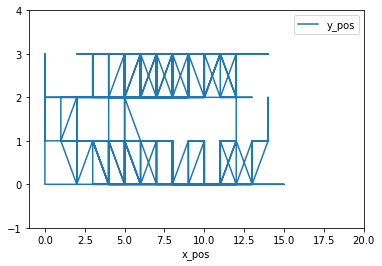

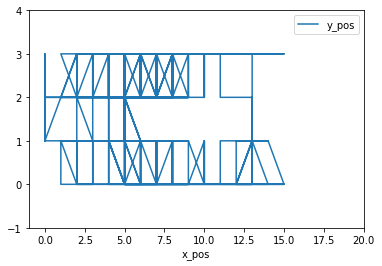

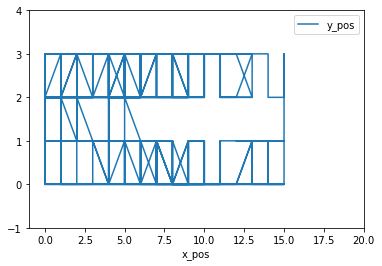

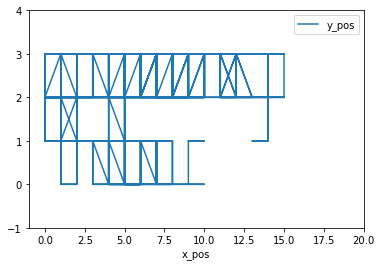

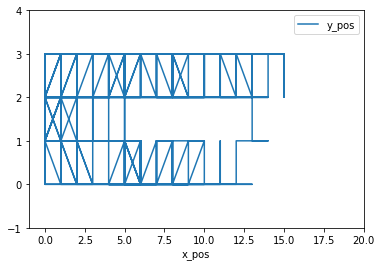

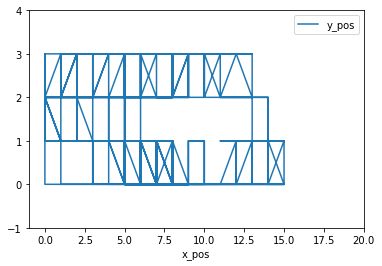

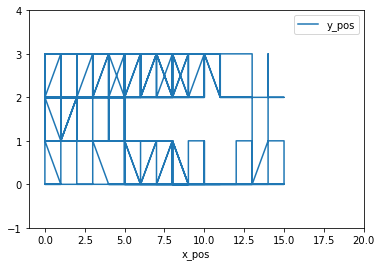

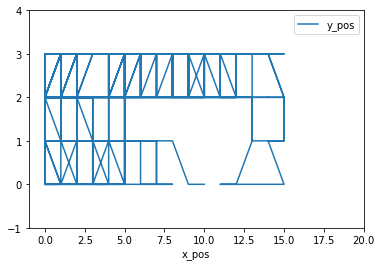

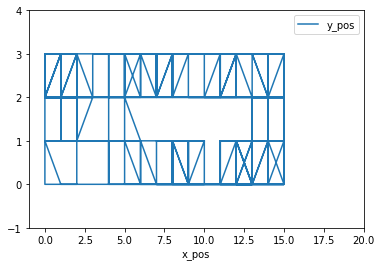

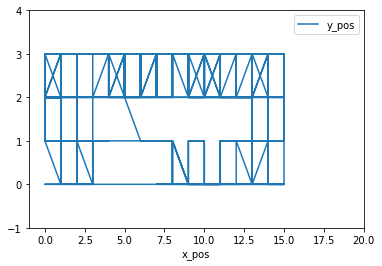

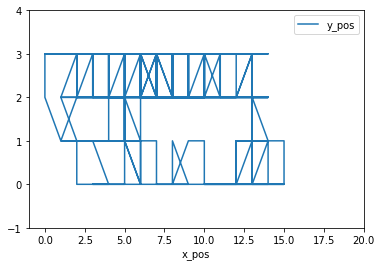

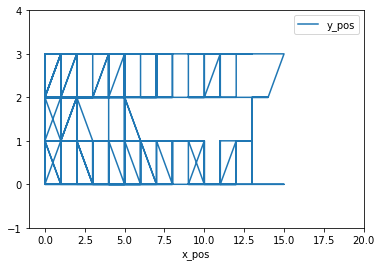

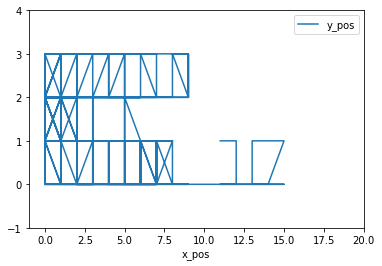

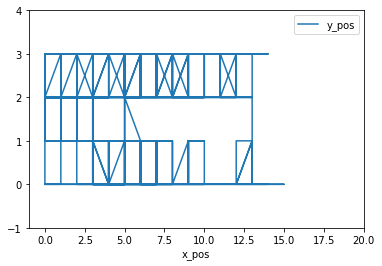

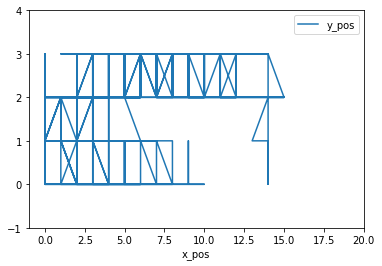

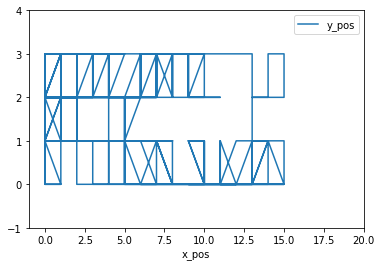

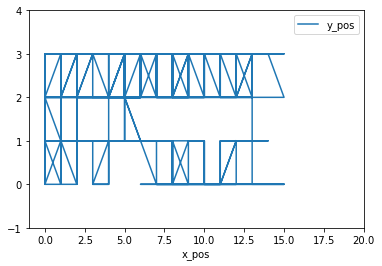

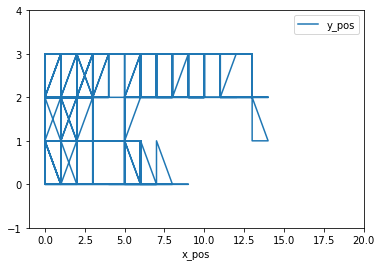

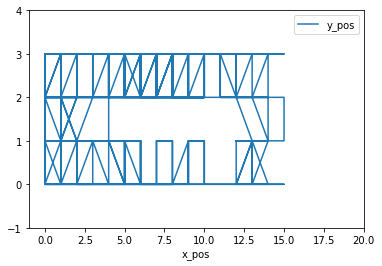

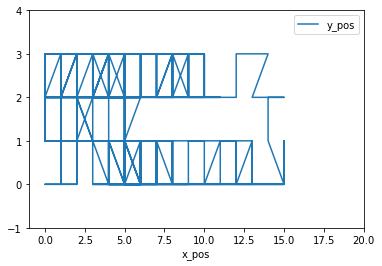

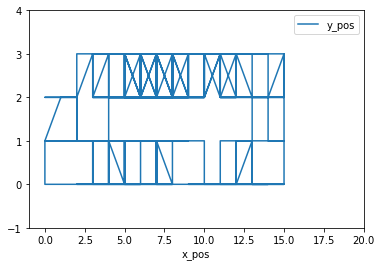

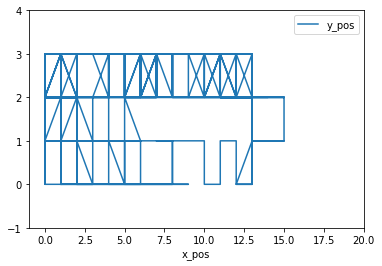

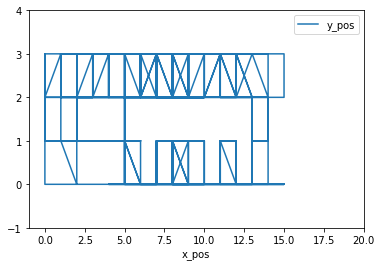

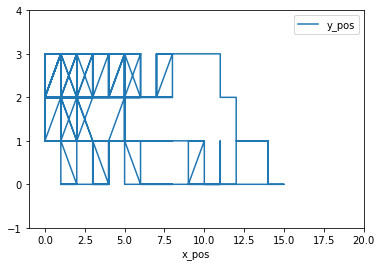

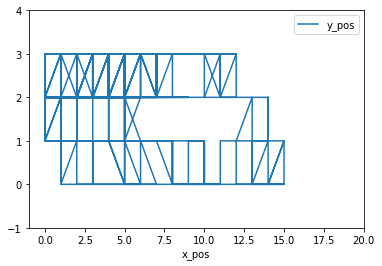

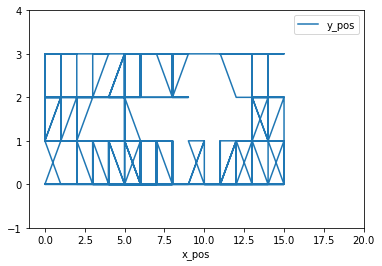

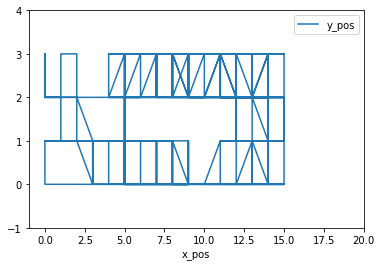

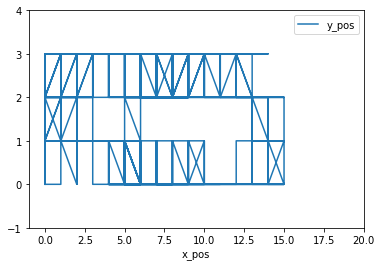

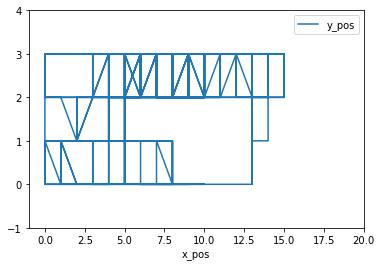

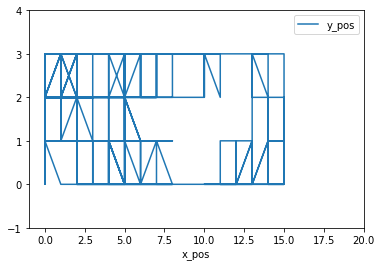

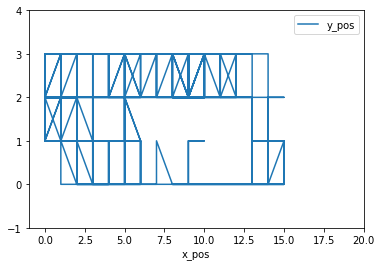

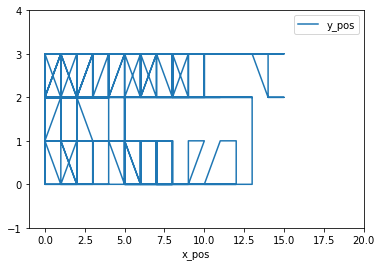

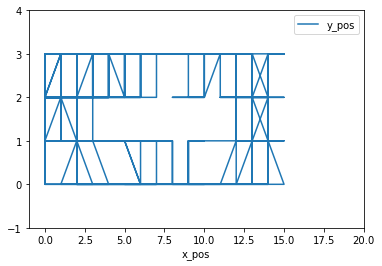

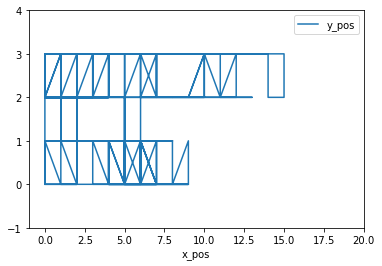

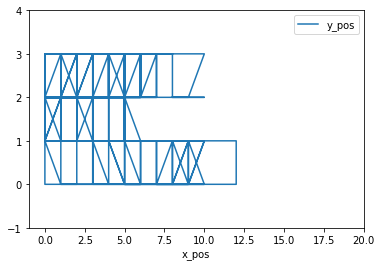

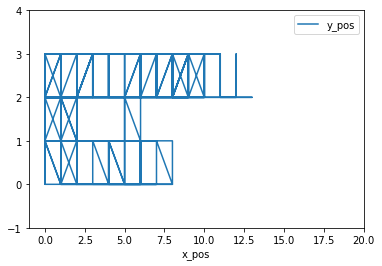

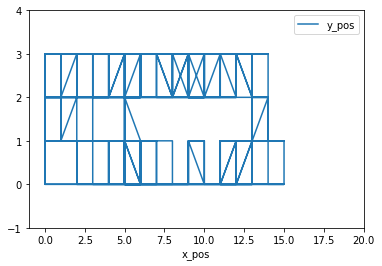

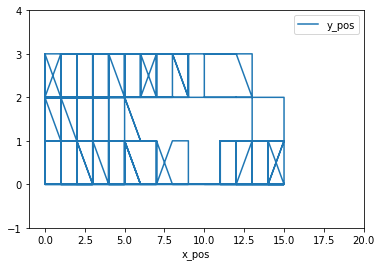

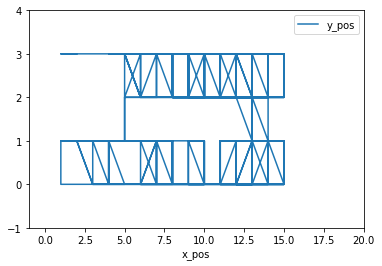

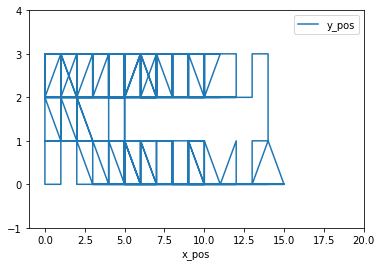

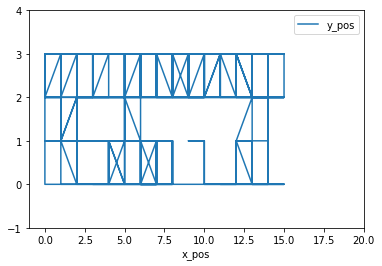

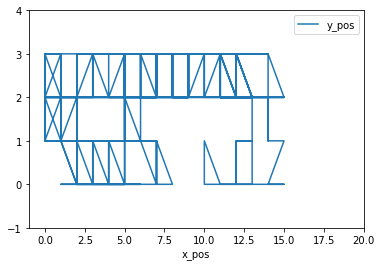

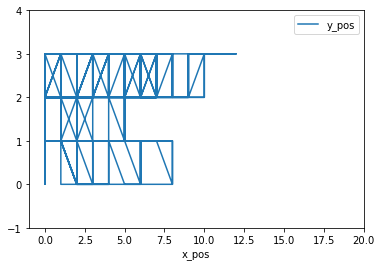

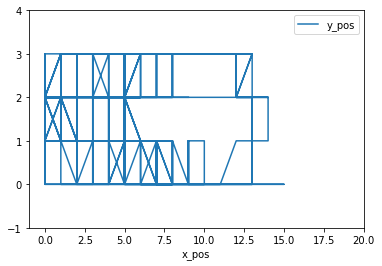

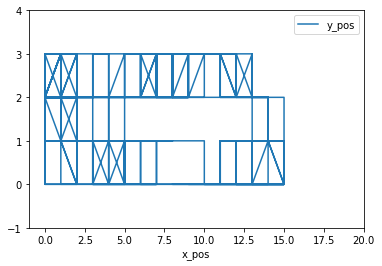

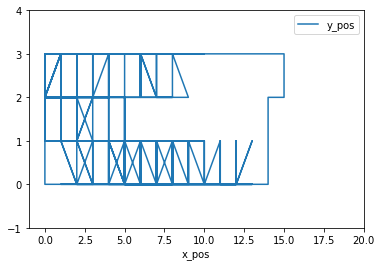

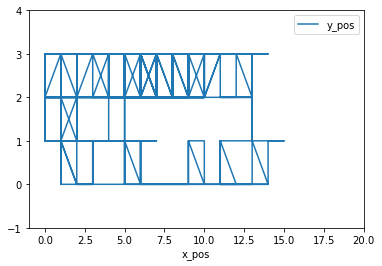

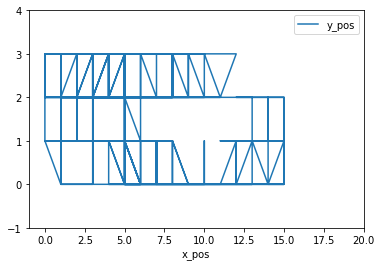

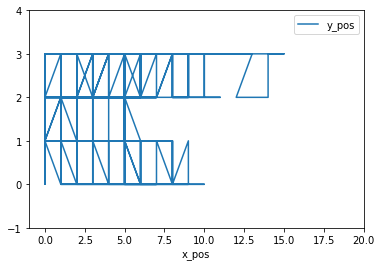

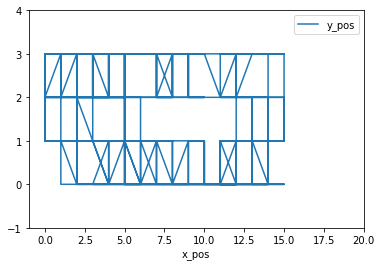

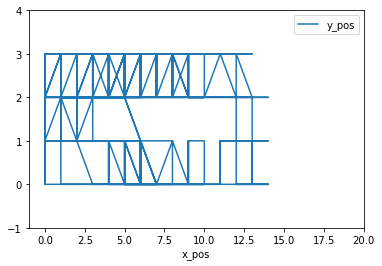

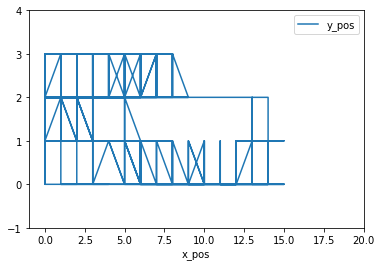

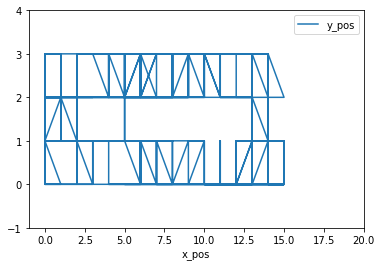

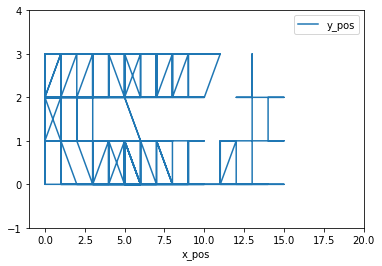

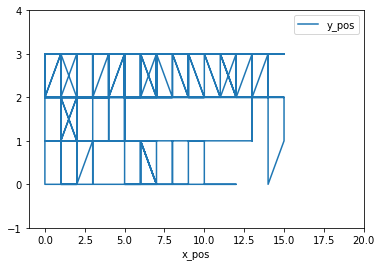

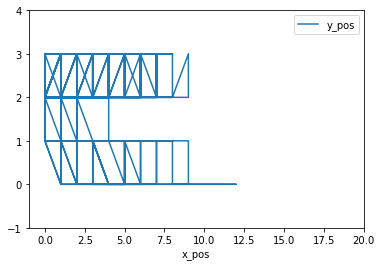

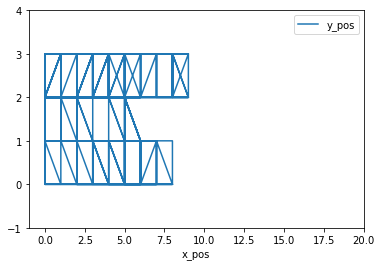

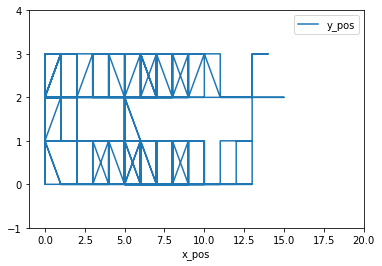

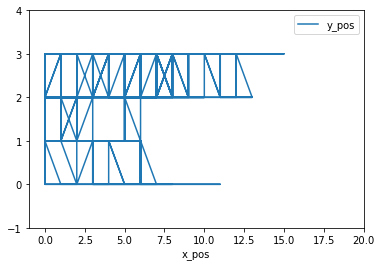

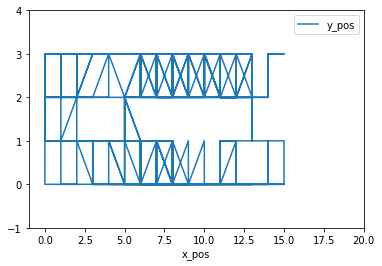

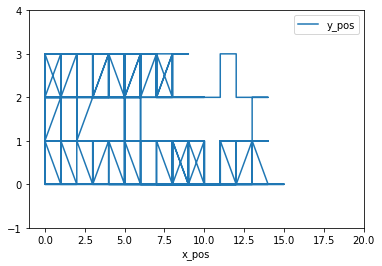

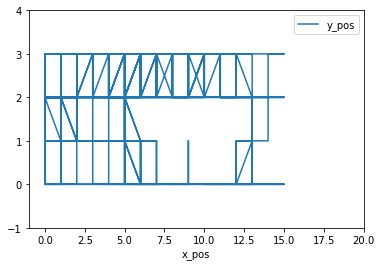

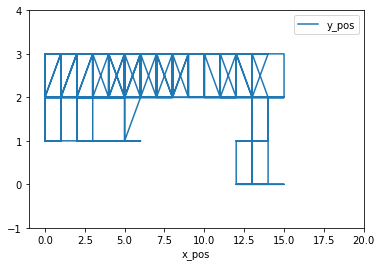

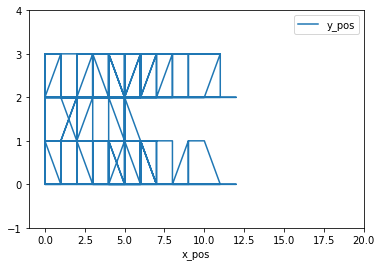

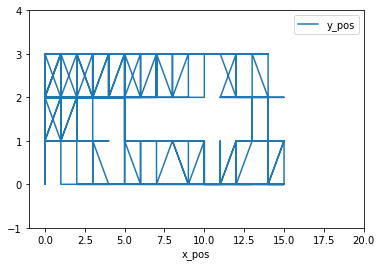

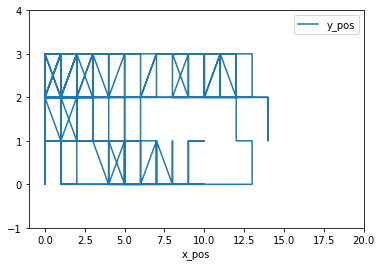

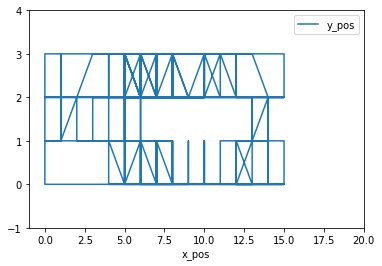

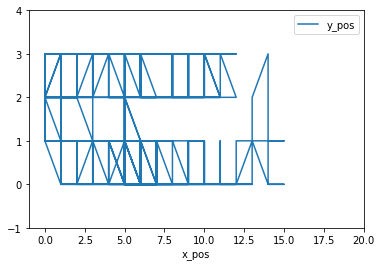

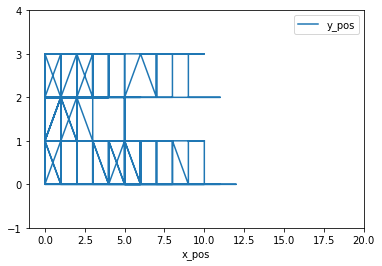

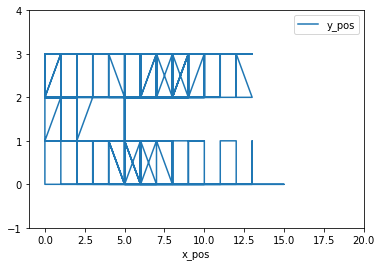

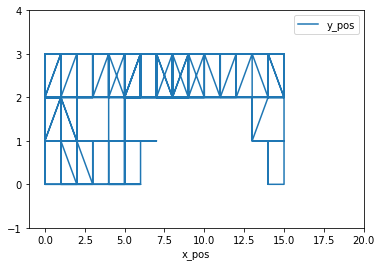

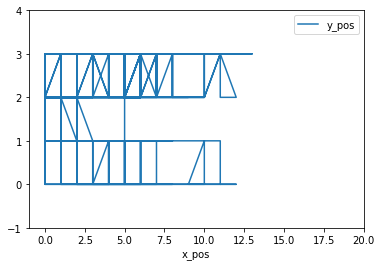

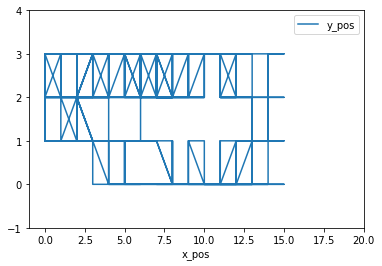

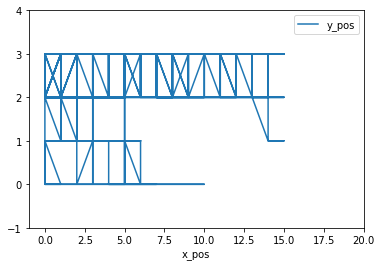

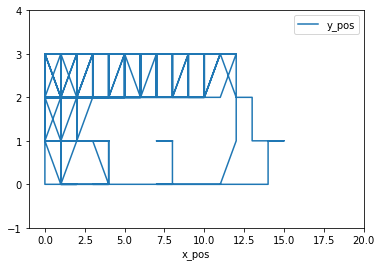

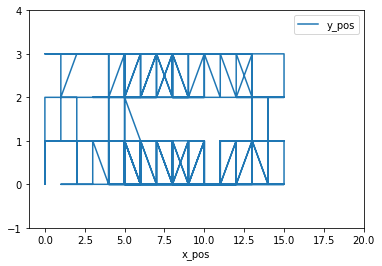

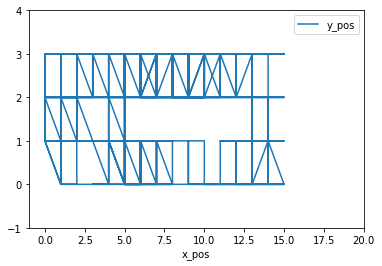

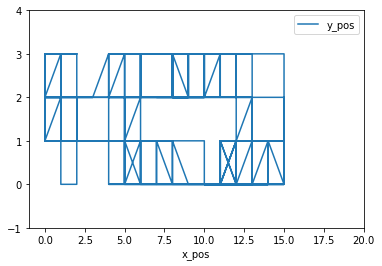

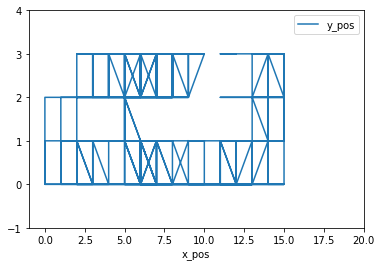

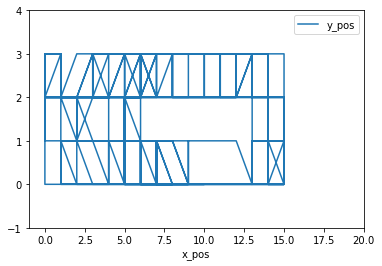

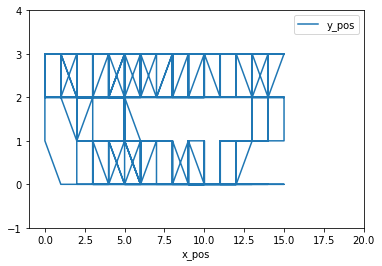

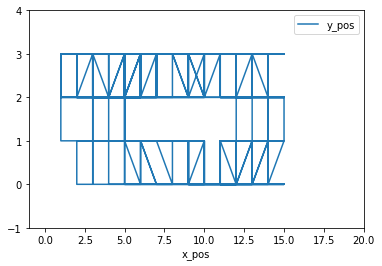

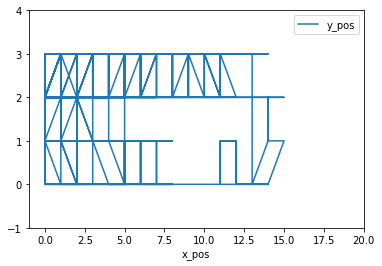

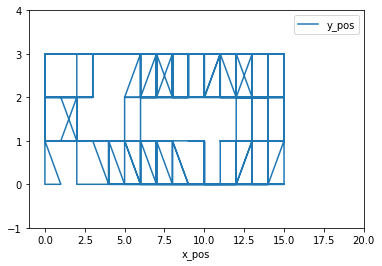

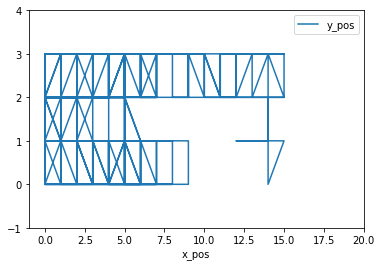

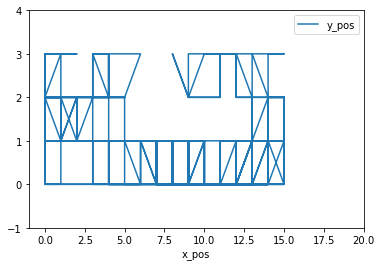

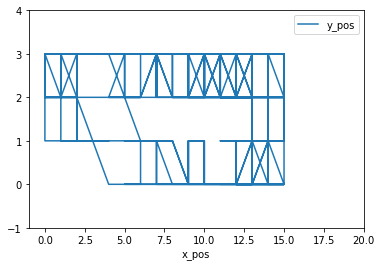

In [17]:
ax = simulation_df.groupby('ID').plot('x_pos','y_pos', xlim = [-1, 20], ylim = [-1,4]);

In [18]:
density_probability_function(np.array([0,1,2,3,4]))

array([1.        , 0.54751026, 0.27306136, 0.10659968, 0.00563558])

In [19]:
density

array([[0.5, 0.5, 0. , 1. , 0.5, 1.5, 0.5, 0.5, 1. , 0.5, 0.5, 0.5, 0. ,
        1. , 0. , 0.5, 0. , 0. ],
       [0.5, 0.5, 2. , 1. , 1.5, 2. , 1. , 1.5, 0.5, 1. , 0. , 0. , 0.5,
        0. , 1. , 0. , 0. , 0. ],
       [2. , 1.5, 1.5, 2. , 3. , 2.5, 1. , 1.5, 1.5, 1.5, 1. , 0.5, 0.5,
        0.5, 1. , 0. , 0. , 0. ],
       [2. , 1.5, 2. , 1. , 1.5, 1.5, 0. , 0.5, 2.5, 0.5, 0.5, 1. , 1.5,
        0.5, 0. , 0. , 0. , 0. ]])

In [21]:
midpoint = (3,14)
current_zone = coordinate_to_zone(midpoint)
density_5 = get_density_matrix(density,current_zone)
density_5

array([0.395, 1.   , 0.   , 0.8  , 0.   , 0.   , 0.8  , 0.   , 0.   ])

In [ ]:
markov_matrix_offboarding[3]

In [ ]:
(np.array([0,1,2,3,4,5,6,7,8]) / 3) - 1